# Libraries import

In [1]:
import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 1 folder(s) up.


# Clusterd and electric network import

In [2]:
solved_4_network = os.getcwd() +  "/results/networks/elec_s_4_ec_lcopt_Co2L-1H.nc"
n_solve_4 = pypsa.Network(solved_4_network)

elec_network= os.getcwd() +  "/networks/elec.nc"
n_elec_pypsa= pypsa.Network(elec_network)

INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


In [3]:
n_solve_4

PyPSA Network
Components:
 - Bus: 12
 - Carrier: 16
 - Generator: 23
 - GlobalConstraint: 1
 - Line: 3
 - Link: 16
 - Load: 4
 - StorageUnit: 3
 - Store: 8
Snapshots: 8760

In [4]:
n_elec_pypsa

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 155
 - Carrier: 13
 - Generator: 318
 - Line: 161
 - Load: 116
 - StorageUnit: 12
 - Transformer: 39
Snapshots: 8760

# Renewable resources

In [5]:
sets_path_to_root("pypsa-earth")
resource_path =  os.getcwd() +  "/resources"
network_path = os.getcwd() +  "/networks"
br = gpd.read_file(f"resources/bus_regions/regions_onshore.geojson")
#br = gpd.read_file(f"{resource_path}/bus_regions/regions_onshore.geojson")
elec = pypsa.Network(f"{network_path}/elec.nc")
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 0 folder(s) up.


INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


In [6]:
import cartopy.crs as ccrs
import cartopy

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):

    if carrier == "solar":
        capacity_per_sqkm = 4.6
    else:
        capacity_per_sqkm = 3.0

    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"resources/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area / capacity_per_sqkm

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=1,
        legend=True,
        legend_kwds={"label": r"Eligible Area [%]"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


    if title is not None:
        plt.title(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29256\768594327.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area / capacity_per_sqkm


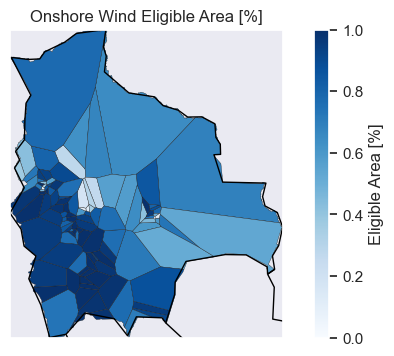

In [7]:
plot_voronoi(
    elec,
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    # ccrs.Orthographic(),
    title="Onshore Wind Eligible Area [%]",
    # filename="onwind-cell.pdf",
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29256\768594327.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area / capacity_per_sqkm


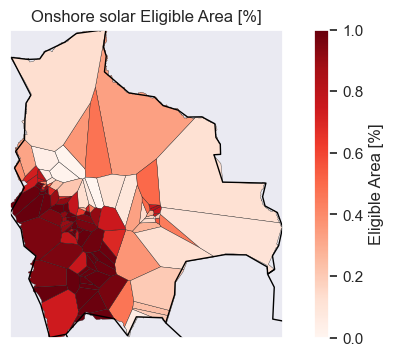

In [8]:
plot_voronoi(
    elec,
    "solar",
    "onshore",
    "Reds",
    ccrs.PlateCarree(),
    # ccrs.Orthographic(),
    title="Onshore solar Eligible Area [%]",
    # filename="onwind-cell.pdf",
)

# Installed powerplants 

In [9]:
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches

In [10]:
OCGT_color='lightcoral'
CCGT_color = 'indianred'
Onwind_color='#ff8200'
Solar_color='gold'
ror_color='lightsteelblue'
reservoir_color='steelblue'
H2_color='darkgoldenrod'
battery_color='tan'
oil_color='black'
biomass_color='#73A917'
demand_color='slategrey'
geothermal_color = 'purple'
load_color=demand_color

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


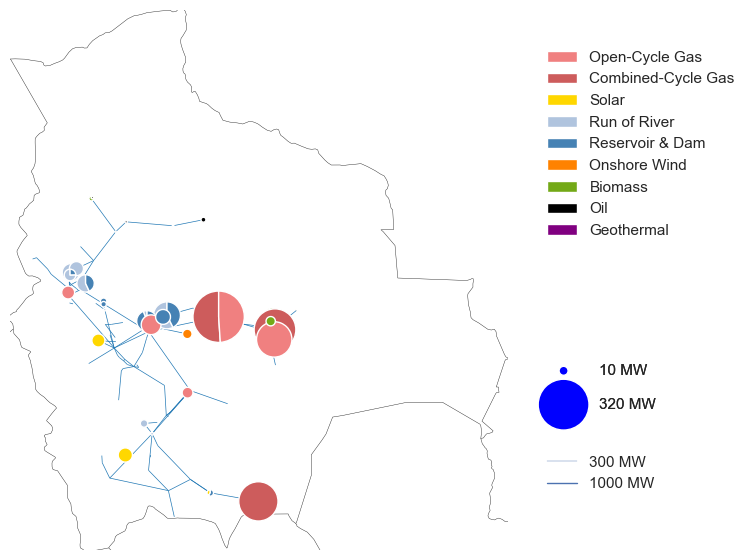

In [11]:
n=n_elec_pypsa


gen = n.generators.groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

bus_scale = 2e3 
line_scale = 1e3

# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 6),subplot_kw={"projection":ccrs.PlateCarree()})

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.05, 0.05, 0.6, 0.9])

# plot your network on the left side of the subplot
n.plot(
    ax=ax,
    bus_sizes=buses / bus_scale,
    line_widths=n.lines.s_nom / line_scale,
    link_widths=n.links.p_nom / line_scale,
    line_colors="tab:blue",
    bus_colors={
        "coal": "#707070",
        "geothermal": geothermal_color,
        "lignite": "#9e5a01",
        "CCGT": CCGT_color,
        "biomass": biomass_color,
        "oil": oil_color,
        "nuclear": "#ff9000",
        "OCGT": OCGT_color,
        "hydro": reservoir_color,
        "onwind": Onwind_color,
        "solar": Solar_color,
        "PHS": "#08ad97",
        "ror": ror_color,
        "H2": H2_color,
        "battery": battery_color,
        "load": load_color,
    },
)

# add a legend to the plot
legend_kwargs = {"loc": "upper left", "frameon": False}
add_legend_patches(
    ax,
    [
        OCGT_color,
        CCGT_color,
        Solar_color,
        ror_color,
        reservoir_color,
        Onwind_color,
        biomass_color,
        oil_color,
        geothermal_color
    ],
    [
        "Open-Cycle Gas",
        "Combined-Cycle Gas",
        "Solar",
        "Run of River",
        "Reservoir & Dam",
        "Onshore Wind",
        "Biomass",
        "Oil",
        "Geothermal"
    ],
    legend_kw={"bbox_to_anchor": (1.05, 0.95), **legend_kwargs},
)
line_sizes = [300, 1000]  # in MW
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s} MW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1.05, 0.2), **legend_kwargs},
)
legend_circles_dict = {"bbox_to_anchor": (1.07, 0.37), "labelspacing": 1.3, **legend_kwargs}
bus_sizes = [10, 320]  # in MW
add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s} MW" for s in bus_sizes],
    legend_kw=legend_circles_dict,
)

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())

# save the plot
image_format = 'png' # e.g .png, .svg, etc.
#fig.savefig('distribution_source_bubbles_2.png', format=image_format, dpi=1200)

# show the plot
plt.show()

# Energy dispatch (total)

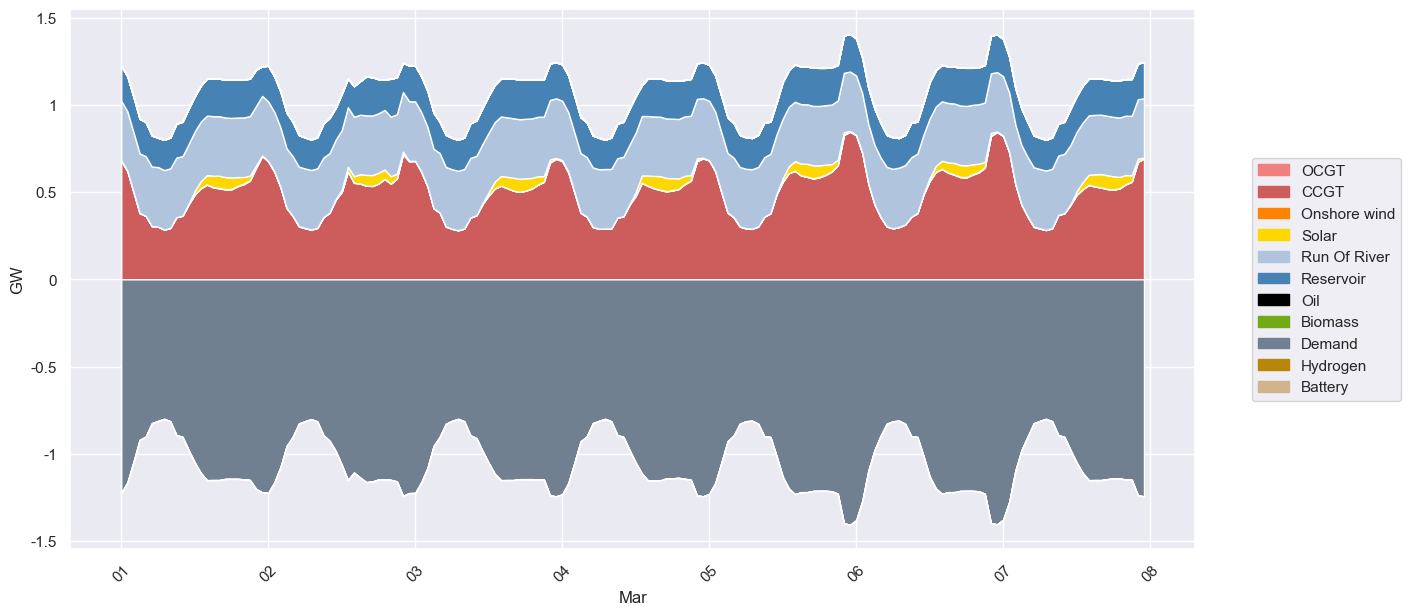

                p_nom     p_nom_opt
carrier                            
CCGT     1.363990e+03  1.363990e+03
OCGT     9.489200e+02  9.489200e+02
biomass  5.558000e+01  5.558000e+01
load     4.000000e+09  4.000000e+09
oil      1.174000e+01  1.174000e+01
onwind   2.654000e+01  2.654000e+01
ror      3.625300e+02  3.625300e+02
solar    1.149000e+02  1.149000e+02

hydro storage : p_nom: 369.67  p_nom_opt: 369.67


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29256\3506261240.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

#solved_4_network = os.getcwd() +  "/results/networks/results_updateRepository/elec_s_4_ec_lcopt_Co2L-4H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

#n = pypsa.Network(solved_4_network)
n = n_solve_4

first_date = "2013-01-01"
second_date = "2013-01-07"
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]

demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1


size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
else:
    biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]
else:
    H2 = np.zeros(size)
    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    
if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)


# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(15, 6))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])

i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 

i=0
nH2 = []
pH2=[]
for i in H2:
    if i < 0:
        nH2.append(i)
    else:
        nH2.append(0) 
for i in battery:
    if i > 0:
        pH2.append(i)
    else:
        pH2.append(0) 



OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
ror_color='lightsteelblue'
reservoir_color='steelblue'
H2_color='darkgoldenrod'
battery_color='tan'
oil_color='black'
biomass_color='#73A917'
demand_color='slategrey'
geothermal_color = 'purple'

A = plt.stackplot(OCGT.index,OCGT,CCGT,Onwind,solar,ror,reservoir, H2, pbattery, oil, biomass, 
colors=[OCGT_color,CCGT_color,Onwind_color,Solar_color,ror_color,reservoir_color,H2_color,battery_color,oil_color,biomass_color], zorder = 3)
plt.stackplot(OCGT.index,demand,nbattery, colors=[demand_color,battery_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Mar')

OCGT_patch = mpatches.Patch(color=OCGT_color, label ='OCGT')
CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')
H2_patch = mpatches.Patch(color=H2_color, label ='Hydrogen')
battery_patch = mpatches.Patch(color=battery_color, label ='Battery')
oil_patch = mpatches.Patch(color=oil_color, label ='Oil')
biomass_patch = mpatches.Patch(color=biomass_color, label ='Biomass')
load_patch = mpatches.Patch(color=demand_color, label ='Demand')
geothermal_patch = mpatches.Patch(color=geothermal_color, label ='Geothermal')


handles=[OCGT_patch,CCGT_patch,wind_patch,solar_patch,ror_patch,reservoir_patch,oil_patch,biomass_patch,load_patch,H2_patch,battery_patch]

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = 'eps' # e.g .png, .svg, etc.

#fig.savefig('energy_dispatch_run4.eps', format=image_format, dpi=1200)

plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))


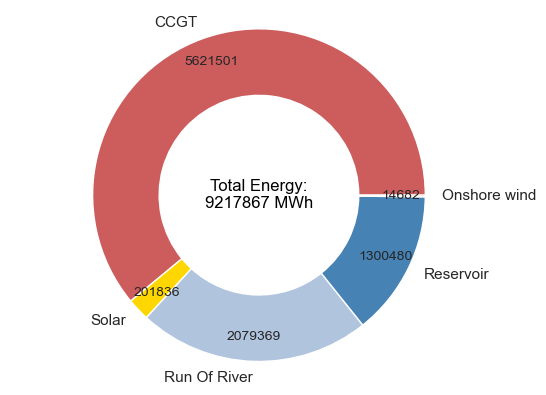

In [13]:
import matplotlib.pyplot as plt
first_date = "2013-01-01"
second_date = "2014-01-01"

time_aggregation = 1   #number hour hours considered by snapshot

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]*time_aggregation
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]*time_aggregation
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]*time_aggregation
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]*time_aggregation


size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]*time_aggregation
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]*time_aggregation
else:
    biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]*time_aggregation
else:
    CCGT = np.zeros(size)

if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]*time_aggregation
else:
    H2 = np.zeros(size)
    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]*time_aggregation
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)*time_aggregation
else:
    reservoir = np.zeros(size)

if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)


# Original data
labels = ['OCGT', 'CCGT', 'Solar', 'Run Of River', 'Reservoir', 'Onshore wind', 'Oil', 'Biomass', 'Geothermal']
sizes = [OCGT.sum(), CCGT.sum(), solar.sum(), ror.sum(), reservoir.sum(),Onwind.sum(), oil.sum(), biomass.sum(), geothermal.sum()]
colors = [OCGT_color, CCGT_color, Solar_color, ror_color, reservoir_color,Onwind_color, oil_color, biomass_color, geothermal_color]

# Filter data based on size > 0.5
filtered_labels = []
filtered_sizes = []
filtered_colors = []

for label, size, color in zip(labels, sizes, colors):
    if size > 10:
        filtered_labels.append(label)
        filtered_sizes.append(size)
        filtered_colors.append(color)

# Calculate the total sum of energy production
total_production = sum(filtered_sizes)

# Function to format the label text with actual values
def format_label(value):
    int_value = int(value)
    return str(int_value)

# Generate the pie chart
plt.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct=lambda x: str(int(round(x * total_production / 100))), pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total Energy:\n{int(total_production)} MWh', fontsize=12, color='black', ha='center', va='center')

#plt.savefig('energy_pie_run4.eps', format=image_format, dpi=1200)
plt.show()


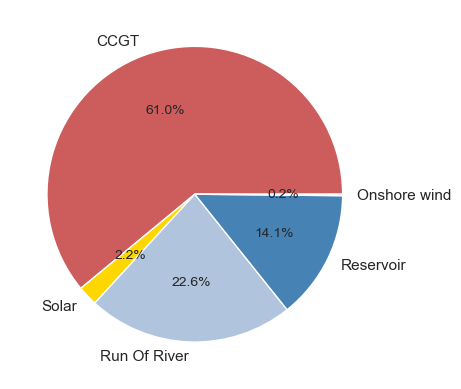

Renewable Energy Percentage: 39.0%
Hydro Energy Percentage: 36.7%


In [14]:
plt.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct='%1.1f%%')
#plt.savefig('energy_pie_run5_percentage.png')
plt.show()

renewable_labels = ['Solar', 'Onshore wind', 'Run Of River', 'Reservoir', 'Biomass' 'Geothermal']
renewable_sizes = [solar.sum(), Onwind.sum(), ror.sum(), reservoir.sum(), biomass.sum(), geothermal.sum()]

hydro_labels = ['Run Of River', 'Reservoir']
hydro_sizes = [ror.sum(), reservoir.sum()]

renewable_sum = sum(renewable_sizes)
hydro_sum = sum(hydro_sizes)
total_sum = sum(sizes)

renewable_percentage = 100 * renewable_sum / total_sum
hydro_percentage = 100 * hydro_sum / total_sum

print("Renewable Energy Percentage: %.1f%%" % renewable_percentage)
print("Hydro Energy Percentage: %.1f%%" % hydro_percentage)

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


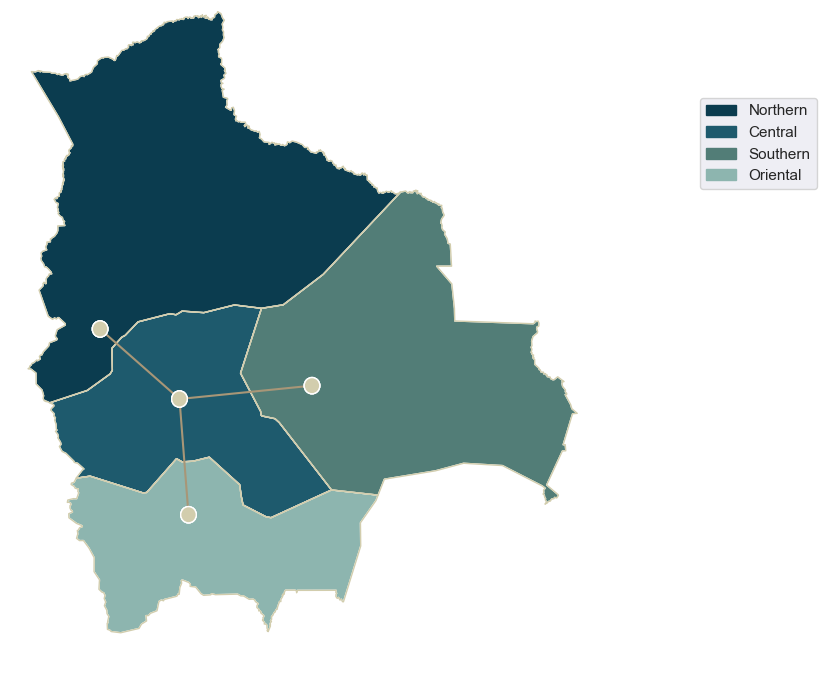

In [15]:
n = n_solve_4
r = gpd.read_file(f"resources/bus_regions/regions_onshore_elec_s_4.geojson").set_index("name")


#Colors:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#0b3c4f'
teal2 = '#1e5a6d'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'


#factor = n.generators_t.p_max_pu.filter(like=plot_capfacs).mean()
#factor.index = [idx.split(f" {plot_capfacs}")[0] for idx in factor.index]
#r["factor"] = factor
fig, ax1 = plt.subplots(subplot_kw={"projection":ccrs.PlateCarree()},figsize = (8,8))

n.plot(ax=ax1,
    color_geomap=False,
    bus_colors=beige3,
    bus_sizes=0.03,
    line_colors=beige2,
    line_widths=1.5
)

# 4 clusters network boundaries
ax1.set_xlim(left=min(n.buses.x)-2.0, right=max(n.buses.x)+7.2)
ax1.set_ylim(bottom=min(n.buses.y)-3.5, top=max(n.buses.y)+6.8)

# Simplified network boundaries
#ax1.set_xlim(left=min(n.buses.x)-2, right=max(n.buses.x)+6.2)
#ax1.set_ylim(bottom=min(n.buses.y)-2.0, top=max(n.buses.y)+5.3)

# Base network boundaries
#ax1.set_xlim(left=min(n.buses.x)-1.7, right=max(n.buses.x)+5.2)
#ax1.set_ylim(bottom=min(n.buses.y)-1.0, top=max(n.buses.y)+4.8)

r.boundary.plot(ax=ax1, color=beige3, linewidth=1, alpha=1) # four zones

zone_colors=[teal2,teal4,teal3,teal1]

r.plot(ax=ax1, column="factor",color=zone_colors,alpha=1, vmin=0, vmax=1) # four zones colored #  color=zone_colors

import matplotlib.patches as mpatches

northern = mpatches.Patch(color=teal1, label ='Northern')
central = mpatches.Patch(color=teal2, label ='Central')
southern = mpatches.Patch(color=teal3, label ='Southern')
oriental = mpatches.Patch(color=teal4, label ='Oriental')

handles=[northern,central,southern,oriental]
ax1.legend(handles=handles, loc="center right", bbox_to_anchor=(1.3, 0.8))



fig.tight_layout()  # Adjust spacing between subplots and labels
# fig.savefig('4zones_division_network.png', bbox_inches='tight')


# Energy dispatch (by bus)

In [16]:
Energy_per_carrier = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()
Energy_per_carrier

carrier,CCGT,OCGT,biomass,load,oil,onwind,ror,solar
snapshot,,,,,,,,
2013-01-01 00:00:00,680.930607,0.000022,0.000016,0.000044,9.419667e-08,1.139150,341.519391,0.000000
2013-01-01 01:00:00,620.125759,0.000022,0.000016,0.000044,9.419666e-08,1.659307,341.513974,0.000000
2013-01-01 02:00:00,500.185253,0.000022,0.000016,0.000044,9.419663e-08,1.838930,341.508558,0.000000
2013-01-01 03:00:00,379.149798,0.000022,0.000016,0.000044,9.419664e-08,1.317127,341.503141,0.000000
2013-01-01 04:00:00,363.386646,0.000022,0.000016,0.000044,9.419664e-08,0.885613,341.497724,0.000000
...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,572.309056,0.000022,0.000016,0.000044,9.419664e-08,0.939011,312.170181,52.181955
2013-12-31 20:00:00,590.992222,0.000022,0.000017,0.000044,9.419665e-08,1.239630,312.263217,39.865272
2013-12-31 21:00:00,607.754747,0.000022,0.000016,0.000044,9.419666e-08,1.105523,312.356252,25.690939


In [17]:
Energy_per_bus = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.bus, axis=1).sum()
Energy_per_bus

bus,BO 0,BO 1,BO 2,BO 3
snapshot,,,,
2013-01-01 00:00:00,127.141110,166.737824,522.035581,207.674716
2013-01-01 01:00:00,127.663619,146.447742,481.518661,207.669100
2013-01-01 02:00:00,127.845595,110.270630,397.753115,207.663483
2013-01-01 03:00:00,127.326144,79.362689,307.623448,207.657867
2013-01-01 04:00:00,126.896983,76.335939,294.884893,207.652250
...,...,...,...,...
2013-12-31 19:00:00,119.529624,159.793889,451.290540,206.986234
2013-12-31 20:00:00,115.336749,153.421696,468.610598,206.991381
2013-12-31 21:00:00,109.459420,151.046271,479.405324,206.996529


In [18]:
n = n_solve_4

###map.py von Fabian
"""
Network expansion plotting functions.
"""

__author__ = "Fabian Neumann (KIT)"
__copyright__ = "Copyright 2019-2020 Fabian Neumann (KIT), GNU GPL 3"

import pandas as pd
import numpy as np

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.1, 0.25, 0.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    for s in (0.1, 0.25, 0.5):
        handles.append(
            plt.Line2D(
                [0], [0], color="darkseagreen", linewidth=s * 1e3 / branch_factor
            )
        )
        labels.append(f"{s} GW")
    l2 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.0, -0.16),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVDC Link Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l2)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")
    for name, carrier in n.carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )
        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [2, 10]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.5,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 1.0e3
    branch_factor = 5e1

    fields = ["bus", "carrier", "p_nom"]
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )

    add_legend(ax, bus_factor, branch_factor)

    ### section added to define the national border
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes=world[world.name.isin(["Bolivia"])].set_index("name")
    ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


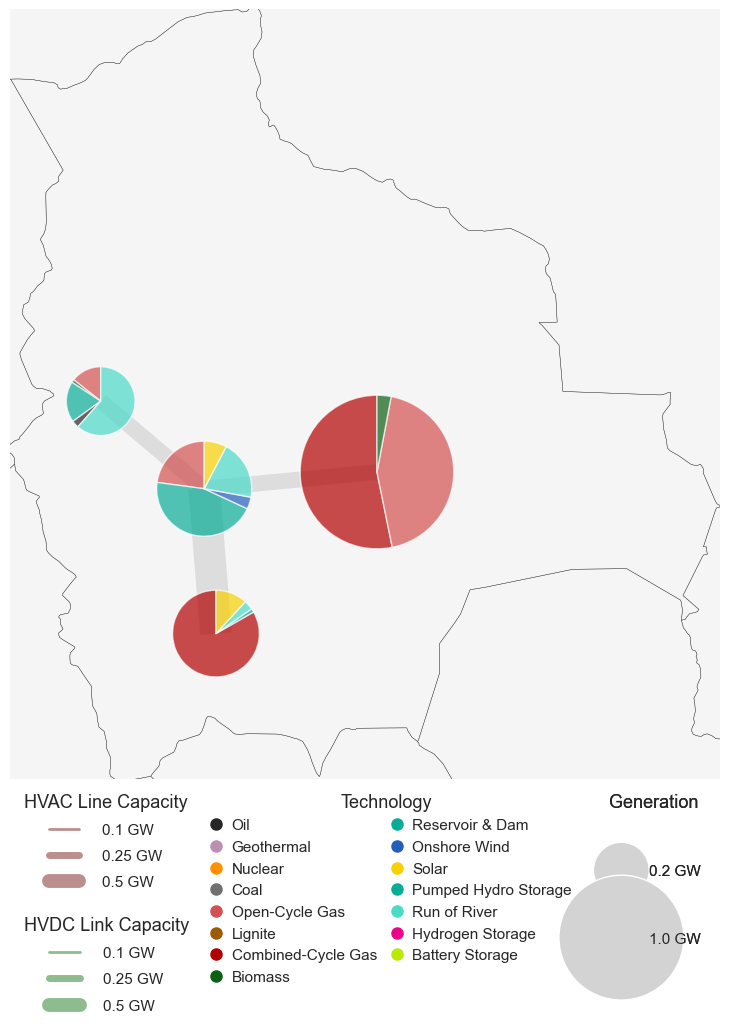

In [19]:

plot_network(n)


In [20]:
bus_names = n.buses.index
bus_names
#OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
#bus_names = n.buses.index
production_by_zone = {}
# Boucle pour obtenir les données des générateurs par bus avec les noms de bus comme index
for bus_name in bus_names:
    # Filtrer les générateurs par zone
    generators_in_zone = n.generators[n.generators.bus.str.startswith(bus_name)]
    total_production = n.generators_t.p.loc[first_date:second_date].groupby(generators_in_zone.carrier, axis=1).sum()
    production_by_zone[bus_name] = total_production

production_by_zone

{'BO 0': carrier                  OCGT      load    onwind         ror      solar
 snapshot                                                                
 2013-01-01 00:00:00  0.000007  0.000011  1.139149  126.001942   0.000000
 2013-01-01 01:00:00  0.000007  0.000011  1.659306  126.004294   0.000000
 2013-01-01 02:00:00  0.000007  0.000011  1.838929  126.006647   0.000000
 2013-01-01 03:00:00  0.000007  0.000011  1.317126  126.008999   0.000000
 2013-01-01 04:00:00  0.000007  0.000011  0.885612  126.011352   0.000000
 ...                       ...       ...       ...         ...        ...
 2013-12-31 19:00:00  0.000007  0.000011  0.939011   97.099473  21.491121
 2013-12-31 20:00:00  0.000007  0.000011  1.239629   97.181760  16.915341
 2013-12-31 21:00:00  0.000007  0.000011  1.105523   97.264047  11.089832
 2013-12-31 22:00:00  0.000007  0.000011  1.312535   97.346334   5.253178
 2013-12-31 23:00:00  0.000007  0.000011  0.689614   97.428622   0.879940
 
 [8760 rows x 5 columns],
 '

IndexError: index 4 is out of bounds for axis 0 with size 4

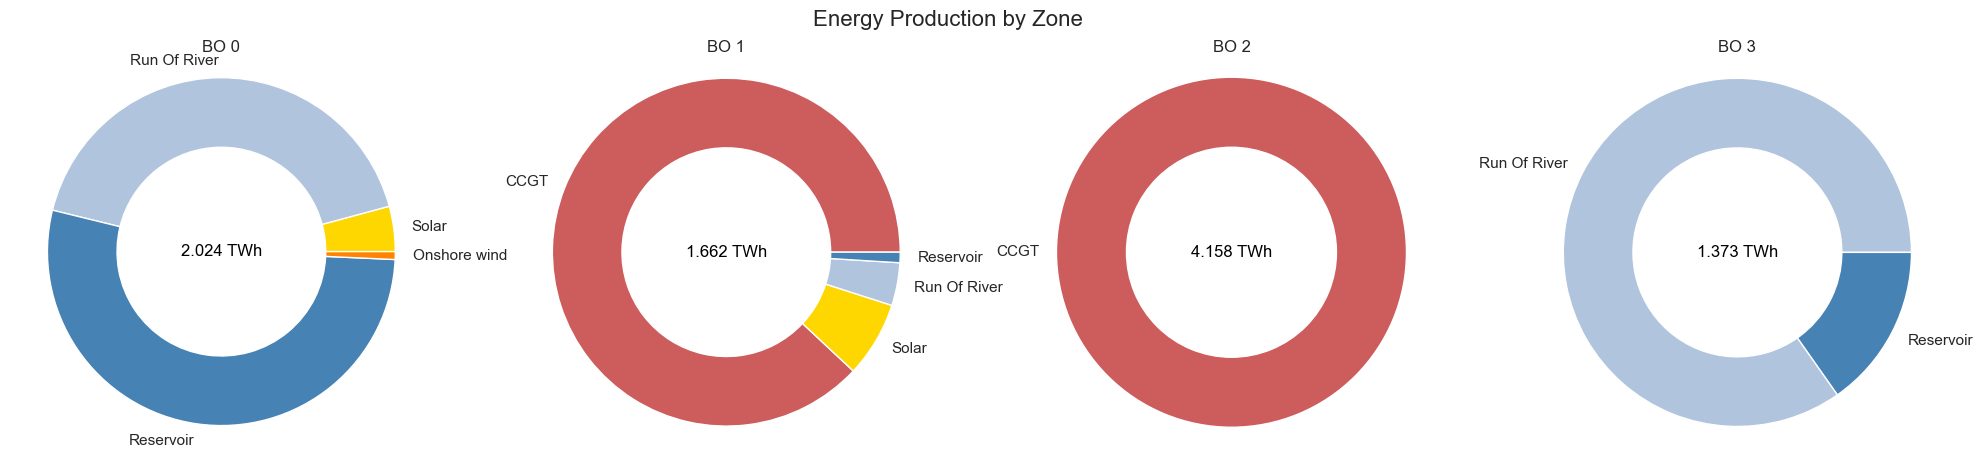

In [21]:
n=n_solve_4

fig, axs = plt.subplots(1, 4, figsize=(25, 5))  # Crée une figure avec 4 sous-graphiques côte à côte
fig.suptitle('Energy Production by Zone', fontsize=16)  # Titre global pour les sous-graphiques

production_by_zone = {}
# Boucle pour obtenir les données des générateurs par bus avec les noms de bus comme index
for i, bus_name in enumerate(bus_names):
    # Filtrer les générateurs par zone
    generators_in_zone = n.generators[n.generators.bus.str.startswith(bus_name)]
    total_production = n.generators_t.p.loc[first_date:second_date].groupby(generators_in_zone.carrier, axis=1).sum()
    production_by_zone[bus_name] = total_production
    
    reservoirs_in_zone = n.storage_units[n.storage_units.bus.str.startswith(bus_name)]
    total_reservoirs = n.storage_units_t.p.loc[first_date:second_date].groupby(reservoirs_in_zone.carrier, axis=1).sum()
    
    labels = ['OCGT', 'CCGT', 'Solar', 'Run Of River', 'Reservoir', 'Onshore wind', 'Oil', 'Biomass', 'Geothermal']
    sizes = []
    colors = []

    # Ajouter la production de chaque source si elle existe dans les données
    if "OCGT" in total_production.columns:
        sizes.append(total_production["OCGT"].sum())
        colors.append(OCGT_color)
    else:
        sizes.append(0)
        colors.append(OCGT_color)

    if "CCGT" in total_production.columns:
        sizes.append(total_production["CCGT"].sum())
        colors.append(CCGT_color)
    else:
        sizes.append(0)
        colors.append(CCGT_color)

    if "solar" in total_production.columns:
        sizes.append(total_production["solar"].sum())
        colors.append(Solar_color)
    else:
        sizes.append(0)
        colors.append(Solar_color)

    if "ror" in total_production.columns:
        sizes.append(total_production["ror"].sum())
        colors.append(ror_color)
    else:
        sizes.append(0)
        colors.append(ror_color)

    if not total_reservoirs.empty:
        sizes.append(total_reservoirs["hydro"].sum())
        colors.append(reservoir_color)
    else:
        sizes.append(0)
        colors.append(reservoir_color)

    if "onwind" in total_production.columns:
        sizes.append(total_production["onwind"].sum())
        colors.append(Onwind_color)
    else:
        sizes.append(0)
        colors.append(Onwind_color)

    if "oil" in total_production.columns:
        sizes.append(total_production["oil"].sum())
        colors.append(oil_color)
    else:
        sizes.append(0)
        colors.append(oil_color)

    if "biomass" in total_production.columns:
        sizes.append(total_production["biomass"].sum())
        colors.append(biomass_color)
    else:
        sizes.append(0)
        colors.append(biomass_color)

    if "geothermal" in total_production.columns:
        sizes.append(total_production["geothermal"].sum())
        colors.append(geothermal_color)
    else:
        sizes.append(0)
        colors.append(geothermal_color)
    
    total_production_sum = sum(sizes)
    

    # Filtrer les données basées sur la taille > 1
    filtered_labels = []
    filtered_sizes = []
    filtered_colors = []
    
    for label, size, color in zip(labels, sizes, colors):
        if size >100:  # Using .any() method to check if any element in the Series satisfies the condition
            filtered_labels.append(label)
            filtered_sizes.append(size.sum())  # Sum the size of the filtered energy source
            filtered_colors.append(color)

    # Générer le diagramme en tarte pour la zone actuelle
    wedges, texts, autotexts = axs[i].pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors,
                                         autopct='', pctdistance=0.85, wedgeprops={'width': 0.4})
    axs[i].axis('equal')

    # Ajouter l'énergie produite au milieu du cercle
    total_energy_produced = sum(filtered_sizes)
    axs[i].text(0, 0, f'{round(total_energy_produced / 1e6, 3)} TWh', fontsize=12, color='black',
                ha='center', va='center')

    # Ajouter le titre de la zone comme titre du sous-graphique
    axs[i].set_title(bus_name)

# Sauvegarder la figure globale
plt.savefig('energy_pie_by_zone.eps', format=image_format, dpi=1200)
plt.show()